In [1]:
from __init__ import PRP; import sys
sys.path.append(PRP)

from scripts.grad_compare import *
from scripts.utils import *

from setups.acc.acc_learning import ACCSetup
from tqdm import tqdm
import gc 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn

from jax import lax

/home/emeunier/code/Veros-Autodiff/
Differentiable Veros Experimental version
Importing core modules
 Using computational backend jax on gpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



2025-10-14 13:24:20.719011: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.9.86). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Spin-up

In [2]:
# Spin-up 
warmup_steps = 20
acc = ACCSetup()
acc.setup()


def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

# Spin-up 
acc = ACCSetup()
acc.setup()

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075
Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Backward vjp - Directional Gradients

# Methods

In [3]:
direction = jax.random.normal(jax.random.PRNGKey(0), acc.state.variables.u.shape)
direction = direction / jnp.linalg.norm(direction)  # normalize

In [4]:
var_agg = 'temp'
def agg_sum(state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    return ((getattr(state.variables, key_sum)[...,tau])**2).mean()
    
agg_function = lambda state : agg_sum(state, key_sum=var_agg)

vjpm = vjp_grad(acc.step, agg_function, var_agg)


vjpm.step_function = jax.jit(vjpm.step_function)
vjpm.agg_function = jax.jit(vjpm.agg_function)

loss_and_grad = lambda s, v, it: vjpm.g(s, v, iterations=it)


In [9]:
%%time
state = state.copy()
field = state.variables.temp

output_forward, gradients = loss_and_grad(state, field, it=2)

CPU times: user 1.47 s, sys: 11.5 ms, total: 1.48 s
Wall time: 1.43 s


In [33]:
def dir_der_autodiff(state, field, direction, step_function, n_iteration) :
    
    def agg_sum(state, key_sum = 'temp') :
        tau = getattr(state.variables, 'tau')
        return ((getattr(state.variables, key_sum)[...,tau])**2).mean()
    
    agg_function = lambda state : agg_sum(state, key_sum=var_agg)
    
    vjpm = vjp_grad_new(step_function, agg_function, var_agg)
    
    loss_and_grad = jax.jit(lambda s, v: vjpm.g(s, v, iterations=n_iteration))

    state = state.copy()
    field = state.variables.temp
    
    output_forward, gradients = loss_and_grad(state, field)
    analytical_dir_deriv = jnp.sum(gradients * direction)
    return analytical_dir_deriv

In [34]:
dir_der_autodiff(state, field, direction, step_function, n_iteration)

Array(-0.00020858, dtype=float64)

Numerical diff

In [31]:
# Numerical directional derivative check for the full tensor

def dir_der_numerical(state, field, direction, step_function,
                      agg_function, n_iteration, epsilon=1e-4) : 

    ndiffm = numerical_diff(step_function, agg_function, var_agg)
    
    def perturb(field, direction, epsilon= 1e-4) : 
        field_pert = field.copy() + epsilon * direction
        return field_pert
    
    forward = lambda f : ndiffm.wrapper(f,
                          state,
                          lambda state : ndiffm.pure(state, step_function),
                          var_agg, agg_function, n_iteration)
    
    field_plus = perturb(field, direction)
    f_plus = forward(field_plus)
    
    field_minus = perturb(field, -direction)
    f_minus = forward(field_minus)
    
    numerical_dir_deriv = (f_plus - f_minus) / (2 * epsilon)
    return numerical_dir_deriv

In [32]:
dir_der_numerical(state, field, direction, step_function,
                      agg_function, n_iteration, epsilon=1e-4)

Array(-0.00020858, dtype=float64)

# Precision vs. iteration

In [38]:
stats = []

for nitt in range(5) :
    s = {'n_iteration' : nitt}
    s['autodiff_grad'] = dir_der_autodiff(state, field, direction, step_function,
                          agg_function, nitt, epsilon=1e-4)
    
    s['numerical_grad'] = dir_der_numerical(state, field, direction, step_function,
                          agg_function, nitt, epsilon=1e-4)
    stats.append(s)
    print(s)

{'n_iteration': 0, 'autodiff_grad': Array(-0.00012743, dtype=float64), 'numerical_grad': Array(-0.00012743, dtype=float64)}
{'n_iteration': 1, 'autodiff_grad': Array(-0.00020858, dtype=float64), 'numerical_grad': Array(-0.00020858, dtype=float64)}
{'n_iteration': 2, 'autodiff_grad': Array(-0.00019662, dtype=float64), 'numerical_grad': Array(-0.00019604, dtype=float64)}
{'n_iteration': 3, 'autodiff_grad': Array(-0.00017864, dtype=float64), 'numerical_grad': Array(-0.00017505, dtype=float64)}
{'n_iteration': 4, 'autodiff_grad': Array(-0.00016696, dtype=float64), 'numerical_grad': Array(-0.00016528, dtype=float64)}


2025-10-09 16:19:54.372749: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-10-09 16:20:34.513964: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m40.141367315s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


{'n_iteration': 5, 'autodiff_grad': Array(-0.00016017, dtype=float64), 'numerical_grad': Array(-0.00016113, dtype=float64)}


2025-10-09 16:27:10.794574: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m28.158825261s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


{'n_iteration': 6, 'autodiff_grad': Array(-0.03631675, dtype=float64), 'numerical_grad': Array(-0.00015078, dtype=float64)}


2025-10-09 16:35:13.831313: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m13.445182311s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


KeyboardInterrupt: 

In [41]:
stats = pd.DataFrame(stats)

In [50]:
stats = stats.melt(id_vars='n_iteration')

ValueError: value_name (value) cannot match an element in the DataFrame columns.

In [53]:
stats['value'] = stats['value'].apply(lambda x : x.item())

In [63]:
stats_g =stats.pivot(columns='variable', index='n_iteration', values='value').reset_index()

In [69]:
stats_g['accuracy'] = 1 - np.abs((stats_g['autodiff_grad'] - stats_g['numerical_grad'])/stats_g['numerical_grad'])

In [72]:
stats_gf =  stats_g.melt(id_vars='n_iteration')

In [77]:
stats_gf.query('')

,n_iteration,variable,value
14,0,accuracy,0.999999
15,1,accuracy,0.999999
16,2,accuracy,0.997026
17,3,accuracy,0.979465
18,4,accuracy,0.989821
19,5,accuracy,0.994020
20,6,accuracy,-238.852972


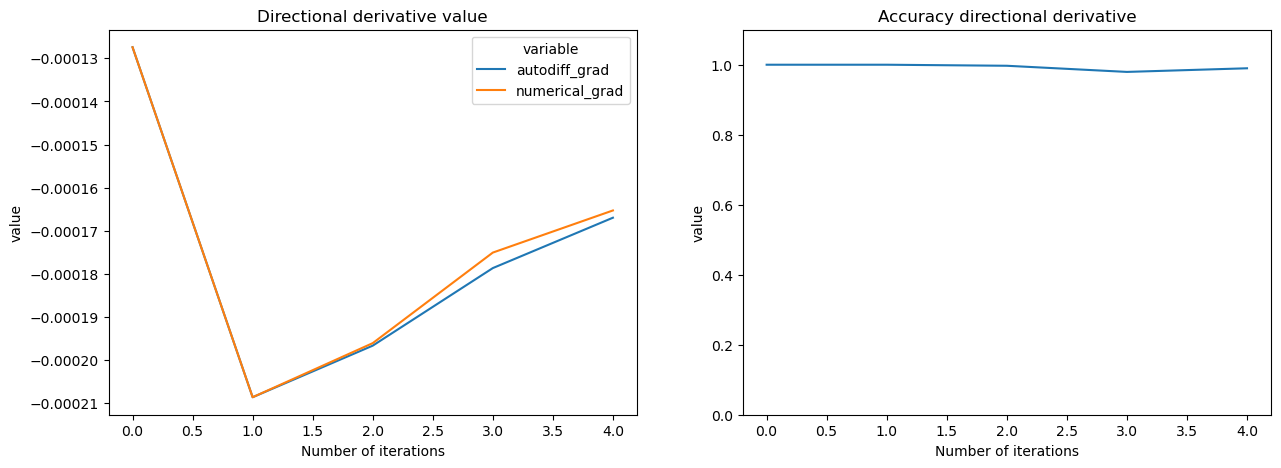

In [99]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(data=stats_gf.query('n_iteration < 5 and variable != "accuracy"'),
             x='n_iteration', y='value', hue='variable', ax=axs[0])
axs[0].set_title('Directional derivative value')
axs[0].set_xlabel('Number of iterations')
sns.lineplot(data=stats_gf.query('n_iteration < 5 and variable == "accuracy"'),
             x='n_iteration', y='value', ax=axs[1])
axs[1].set_title('Accuracy directional derivative')
axs[1].set_ylim([0,1.1])
axs[1].set_xlabel('Number of iterations')
fig.savefig(f'figures/directional_derivative_accuracy_{datetime.now().strftime("%d%m%y")}.png')

In [1]:
stats

NameError: name 'stats' is not defined

In [ ]:
w